In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec

from konlpy.tag import Okt
from konlpy.tag import Mecab
from khaiii import KhaiiiApi

import numpy as np
from collections import Counter
import re
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN,KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1. 재해개요에 대해 Word2Vec 임베딩, t-SNE를 통한 시각화.

In [55]:
# 재해개요 Data Load
df = pd.read_excel("fire_data.xlsx")
df

,연번,기준연월,발생형태_소,재해개요
0,43,201212,화재,주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우징...
1,120,201212,폭발·파열,[비보고 사유] 가스주입실에서 이송대기중 질소가스통 체결부위 불량으로 폭발되면서 파...
2,197,201212,폭발·파열,[비보고 사유] 재해 발생시 산업재해발생 보고를 해야 한다는 사실을 알지 못함 [조...
3,394,201212,폭발·파열,[비보고 사유] 재해자가 본인 실수로 다쳤으므로 본인이 알아서 한다고 하여 방치한 ...
4,478,201212,폭발·파열,[비보고 사유] 공상처리 [조사자 견해] 유성기업(주)에서 제출한 공상처리 내역 및...
...,...,...,...,...
1814,495010,201712,화재,상기일 상기인 호스를 연결하기 위해 녹이는 과정에서 사고가 발생.(신나에 불이 옮겨...
1815,495567,201712,화재,12월 07일 오전07시경 제품(무거리) 보관용기로 사용하기 위해 폐드럼통 뚜껑 산...
1816,495930,201712,폭발·파열,2017년 12월 12일 14시 48분경 회사 공장동에서 기계시운전을 하면서 온도상...
1817,496127,201712,화재,2017년 12월 18일 13시경 부산시 강서구 송정동 소재 부광화학공업(주) 본공...


In [3]:
# 불용어 정의
df_stopwords = pd.read_excel('stopwords.xlsx')
df_stopwords

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
717,더욱이
718,도달
719,돼다
720,되다


In [4]:
# 카카오에서 개발한 형태소 분석기 KhaiiiApi
api = KhaiiiApi()
sentence_list = []
morphs_list = []
df = pd.read_excel("fire_data.xlsx")
df_stopwords = pd.read_excel('stopwords.xlsx')
stopwords = list(df_stopwords['불용어'])


for sentence in df["재해개요"]:
    if sentence != '':
        # 모든 문장
        if '.' in sentence:
            sentence_detail = sentence.split('. ')
            for i in sentence_detail:
                if i != '':
                    sentence_list.append(i)
        else:
            sentence_list.append(sentence)

for s in sentence_list:
    print(s)
    print()
# print(sentence_list[0])

주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우징 기계를 이용하여 작업하던 중 가우징 불똥이 내경 단차부위에 두딪혀 작업자 쪽으로 뛰어 점퍼에 불이 붙었으나, 방독마스크와 용접면을 쓰고 있어서 불이 붙은 줄 모르다가 늦게 인지하여 왼쪽팔과 가슴쪽에 화염화상을 입음.

[비보고 사유] 가스주입실에서 이송대기중 질소가스통 체결부위 불량으로 폭발되면서 파편에 복부를 강타하여 부상을 입고 병원 치료를 하여 국민건강보험공단으로부터 부당이득금 환수조치된 건임 [조사자 견해] 법규정을 몰랐고 사고가 경미하여 산업재해조사표를 제출하지 않은 건으로 최근 3년이내 산재발생미보고로 처분 받은 사실이 없으므로 경고조치 후 종결코자 합니다

※ 붙임: 산재발생미보고 경위서 및 산업재해조사표 [작업장소] 사업장 내 가수주입실 [작업목적] 가스주입 후 이동대기 중 [작업도구] 가스주입기 [작업내용] 이송대기 적재중에 [재해사유] 체결부위 미세불량으로 [재해발생] 체결이 분리되면서 파편이 복부강타

[비보고 사유] 재해 발생시 산업재해발생 보고를 해야 한다는 사실을 알지 못함 [조사자 견해] 경고 조치를 하고자 함 [작업장소] 상기 사업장 내에서 [작업목적] 불을 피우기 위하여 [작업도구] 락카통을 사용하여 [작업내용] 부주의로 [재해사유] 없음 [재해발생] 락카통이 폭발하여 얼굴에 화상을 입음

[비보고 사유] 재해자가 본인 실수로 다쳤으므로 본인이 알아서 한다고 하여 방치한 것으로, 담당자가 산재처리 절차에 미숙하여 건강보험공단 환수처리로 마무리된 것으로 오인함

[조사자 견해] 재해정도가 경미하고 사업주의 고의성이 없는 것으로 판단하여 경고 조치후 종결하고자 합니다 [작업장소] 작업장내에서 [작업목적] 휴식중 추위를 피하기 위해 [작업도구] 불을 피우기 위해 [작업내용] 스레기 등을 모아 [재해사유] 불을 붙였다가 [재해발생] 더미속에 섞인 락카가 폭발하면서 목에 화상을 입음

[비보고 사유] 공상처리 [조사자 견해] 유성기업(주)에서 제출한 공상처

용제 불통이 옷에 데여 불이 붙으면서 화상을 입었습니다(2014년 6월 19일 11시 남성테크 공장내)

동명특수산업(경남 김해시 동북로 513번길 80) 2014년 6월 25일 오후2시경 긴급으로 의뢰받은 제품을 속건시키기 위해 제품을 1,2,3 번 건조실중 3번 건조실에 넣어두었고 오후 5시 20분경 퇴근하기 위해 건조실에 
있는 제품을 꺼내려 가던중 밑에 깔려있는 열건조기 배선에서 스파크가 제품으로 튀었고 에폭시계열의 약품이 들어가있는 제품에 불이 붙었습니다
제품을 들고 있던 작업자(이정섭)의 옷에도 옮겨 붙었고 그로인해 화상을 입었습니다
나일론 계열의 옷차림이었고 끼고 있던 장갑으로 문을 두들겨 불을 끄고 뛰어나와 물을 몸에 기얹졌습니다
그리고 바로 회사차로 병원으로 갔습니다

에탄올을 다루는 실험을 하던 중 에탄올이 바닥으로 흘러 옆에서 작업중이던 실험에서 불이 옮겨 붙어 화재가 발생하였다

곧 스프링클러가 작동하여 진화되었고 팔과 다리에 화상을 입었다.

2014.06.25

9시경 당사 화성공장 쓰레기 소각장에서 쓰레기 소각중 불씨가 옷(상의)에 접해져 화상을 입음

2014년 6월 28일 오후 3:00경 강서구 송정동 소재 영우정공 작업장에서 쇼트기 작업중 폭발로 인한 다리부위 옷에 불이 붙으면서 두다리에 화상을 입었습니다.

2014년 6월 30일 경기도 안성시 죽산면 두현리 522-1번지 내에서 외부에 설치한 집진기 안에 화재가 발생하여 화재를 진압 하고자 집진기 문을 열다 폭발하여 화상을 입음

2014년 6월 30일 오후 16시 30분경 안성시 죽산면 두현리 522-1소재

집진기에서 화재 발생하여 소화기로 불을 진압하려고 문을 개폐하던중 화염이 밖으로 나와 일어난 사고임

2014년 6월 30일 오후 16시30분경 안성시 죽산면 두현리 522-1소재

집진기에서 화재가 발생하여 소화기로 불을 진압하려고 문을 개폐하던중 화염이 밖으로 나와서 좌측상지에 화상입음.

2014년 6월 30일 오후 4시 30분경 경기 안성시 죽산면 두현리 522

공장내 레디알드릴기의 도색작업을 위해 헝겁에 신나를 묻혀 기계의 기름때를 제거 작업을 하였고 작업하던 기계주변에 흘러내린 신나 및 신나가 묻은 헝겁이 흩어져 있었는데 옆에서 근로자 조성보씨의 글라인더 작업으로 불통이 튀면서 신나에 불이 붙어 얼굴에 화상을 입게 됨.

플라스틱 용기에 묻은 유분을 세척한 후 남아있는 유분을 보루 또는 헝겁으로 닦아내야 했으나 저온로에 넣어서 건조하는 공정중 잔존하는 유분이 열에의하여 유증기가 발생하며 작은폭발이 발생하여 화상상해를입음

2017년 02월 24일 04시경 연주산업 생산현장에서 림사이가 야간 근로중에 날씨가 추워 드럼통 난로에 불을 붙이다가 불이 잘 붙지 않아 주변에 있던 신나를 뿌리고 불이 붙이던 중 신나 소량이 옷에 뭍어 불이 옷에 옮겨 붙어 다침.

고철 절단을 위해 재해자 (최병진)가 고압산소 작업중 산소 역학 (산소불대안으로 불이 빨려 들어 가는 현상) 으로 인해 산소호스가 터지면서 불이 재해자의 오른쪽 얼굴과 오른쪽 팔에 옮겨 붙으며 재해가 발생함.

2017년 3월 2일 17시경 제품 생산 중 바닥으로 낙하하던 고온의 스크랩으로 인해 설비에 화재가 발생하자 스크랩박스를 당기면서 모래로 화재를 진압하던 중 역비산하는 모래(마그네슘)와 스크랩에 화상 사고.

상기일 사기인 베일프레스실 내부에 설치된 코마노일 베일프레스에 화재가 발생되어 베일프레스 측면 문을 열고, 소화전을 사용하여 화재 진화 도중 베일프레스 내부 상단에 걸려 있던 노일에 붙은 불씨가 갑자기 정면으로 날리면서 얼굴, 목, 복부, 양팔, 허벅지, 종아리 부위에 2도 정도의 화상 피해가 발생 됨.

*임금자료 및 의무기록지 파일로 첨부.

재해자가 버티칼 라다 레그 서포트 절단 작업 중, 비산된 불씨가 재해자 오른쪽 허벅지 뒷편 작업복에 붙어 화상을 입은 사고 임.

2017년 3월 9일 본인은 상기 사업장내에서 토치를 사용한 실습중 동료 근로자 석광현의 지시로 석광현이 들고 있던 용접봉에 본인의 토치로 열을 가하여 주었습니다

이후 석광현은 달

In [5]:
morphs_list = []
sentence_nouns_list = []

api = KhaiiiApi()

# 모든 문장에서 명사만 추출
for sentence in sentence_list:
    morphs_value = []
    for word in api.analyze(sentence):
        for morph in word.morphs:
            if morph.tag == 'NNG' and morph.lex not in stopwords: # 명사 추출, 불용어 제거
                morphs_list.append(morph.lex)
                morphs_value.append(morph.lex)
    sentence_nouns_list.append(morphs_value) # 각 문장별 명사 리스트 구별

morphs_list # 행 구분 없이 전체 단어 리스트 
sentence_nouns_list # 행 구분한 전체 단어 리스트 

[['주조',
  '사업',
  '장',
  '가우징',
  '작업장',
  '안쪽',
  '소착',
  '제거',
  '징',
  '기계',
  '이용',
  '작업',
  '징',
  '불똥',
  '내경',
  '단차부위',
  '작업자',
  '점퍼',
  '불',
  '방독마스크',
  '용접면',
  '불',
  '인지',
  '왼쪽팔',
  '가슴',
  '화염',
  '화상'],
 ['사유',
  '가스주입실',
  '이송',
  '대기',
  '질소가스통',
  '체결',
  '부위',
  '불량',
  '폭발',
  '파편',
  '복부',
  '강타',
  '부상',
  '병원',
  '치료',
  '국민',
  '건강',
  '보험',
  '공단',
  '부당',
  '이득금',
  '환수',
  '조치',
  '건임',
  '조사자',
  '견해',
  '법',
  '규정',
  '사고',
  '경미',
  '재해조사표',
  '제출',
  '최근',
  '산재',
  '발생미보고',
  '처분',
  '사실',
  '경고',
  '조치',
  '종결',
  '코자'],
 ['붙임',
  '산재',
  '발생미',
  '경위서',
  '재해조사표',
  '작업',
  '소',
  '사업장',
  '가수',
  '주',
  '입실',
  '작업',
  '목적',
  '가스주입',
  '이동',
  '대기',
  '작업',
  '가스주입기',
  '작업',
  '내용',
  '이송대기',
  '적재',
  '재해',
  '사유',
  '체결',
  '부위',
  '미세',
  '불량',
  '해',
  '발생',
  '체결',
  '분리',
  '파편',
  '복부',
  '강타'],
 ['사유',
  '재해',
  '발생',
  '재해발생',
  '보고',
  '사실',
  '조사자',
  '견해',
  '경고',
  '조치',
  '함',
  '작업',
  '장소',
  '상기',
  '사업장',
  '작업',
  '목적',
  '불',

In [6]:
model = Word2Vec(sentences = sentence_nouns_list,
                 vector_size=200, # 차원 
                 window=5, # 훈련시 앞 뒤로 고려하는 단어의 개수
                 min_count=5, # 해당 빈도수 보다 작게 등장한 단어의 경우 모델 학습 배제
                 sg=1, # skip-gram
                 workers = 4, # 모델을 만들때 스레드 개수 
                 sample = 1e-3) # 전체 데이터에서 많이 등장하는 단어는 그만큼 학습 기회가 많으므로 이런 학습량을 확률적인 방식으로 줄이기 위한 변수
model.wv.vectors.shape
model.init_sims()

<ipython-input-6-3c302c1f1127>:9: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims()


In [12]:
num_words = 200
word_embeddings = pd.DataFrame(model.wv.vectors[:, :], index=model.wv.index_to_key[:])
word_embeddings

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
작업,-0.016278,-0.136576,0.020132,-0.033433,0.248027,-0.191357,-0.155845,0.242776,0.085235,0.030506,...,0.153787,0.000794,-0.123002,-0.081448,0.021444,0.038261,-0.050410,-0.065758,0.140354,-0.017218
화상,-0.013678,0.069750,-0.079625,0.004143,0.233263,-0.074191,-0.004157,0.093610,-0.061808,0.056715,...,-0.210791,0.094609,-0.004059,0.128240,0.287123,0.019914,0.000659,-0.214200,-0.091222,-0.051822
발생,-0.047303,0.034815,-0.031489,-0.013198,0.196850,-0.139733,-0.106132,0.211254,0.003583,0.028734,...,-0.078323,0.081442,-0.018468,0.080995,0.182914,-0.025903,-0.030106,-0.154066,0.069612,-0.058182
불,-0.035631,-0.077409,-0.087876,-0.018323,0.241492,-0.157993,-0.011920,0.167278,0.038325,0.067305,...,-0.095798,0.072925,-0.050321,0.128705,0.161611,0.106158,-0.061748,-0.230197,0.042402,-0.085987
폭발,-0.035614,-0.047569,-0.026666,-0.035425,0.247796,-0.131179,-0.099030,0.120799,0.053130,0.037988,...,-0.095806,0.090504,-0.037552,0.059969,0.137506,0.013739,-0.000152,-0.123160,0.049550,-0.018146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
처리장,-0.022480,-0.008458,0.018946,-0.007321,0.183860,-0.067387,-0.109285,0.148974,-0.003051,0.037002,...,0.044973,0.000834,-0.055996,-0.036709,0.105027,0.017595,0.001654,-0.069318,0.030151,-0.002956
메탄가스,-0.023747,-0.027816,0.016987,-0.018487,0.216917,-0.095530,-0.122373,0.161819,0.014584,0.049503,...,0.034997,0.015102,-0.069143,-0.028495,0.123249,0.028428,-0.007003,-0.086583,0.034343,-0.015506
게이지,-0.023358,-0.020949,0.018640,-0.013168,0.221947,-0.095110,-0.128370,0.164643,0.016030,0.042009,...,0.042104,0.009470,-0.064655,-0.038581,0.115129,0.022021,-0.003020,-0.076444,0.047421,-0.008581
화요일,-0.026082,-0.010945,0.021791,-0.010162,0.181377,-0.071194,-0.106920,0.140445,-0.001203,0.035511,...,0.041575,-0.001454,-0.052329,-0.040903,0.106759,0.021778,0.001923,-0.066587,0.027782,-0.001293


In [13]:
# target과 가장 유사한 단어 뽑기 (결과가 잘 나오는것 을 알수 있음)
target = "화재"
print(model.wv.most_similar(target))

[('진압', 0.9484941959381104), ('발생', 0.9481887221336365), ('소화기', 0.9401511549949646), ('원인', 0.9393453001976013), ('미상', 0.9195892214775085), ('대피', 0.9150593280792236), ('스파', 0.907732367515564), ('진화', 0.9006388187408447), ('추정', 0.8902186751365662), ('불명', 0.8878652453422546)]


In [14]:
tsne = TSNE(random_state=0,
            learning_rate = 50,
            n_components = 2 # 2차원
           )
tsne_points = tsne.fit_transform(word_embeddings.values)

In [15]:
tsne_df = pd.DataFrame(tsne_points, index=word_embeddings.index, columns=['x_coord', 'y_coord'])
tsne_df['word'] = tsne_df.index
tsne_df

,x_coord,y_coord,word
작업,3.467880,-42.186924,작업
화상,-34.486176,-5.083155,화상
발생,-30.794836,-11.807120,발생
불,-34.326080,-8.059634,불
폭발,-28.592180,-8.514859,폭발
...,...,...,...
처리장,4.698897,47.062954,처리장
메탄가스,1.333156,19.227772,메탄가스
게이지,16.149439,10.007450,게이지
화요일,3.624636,48.043419,화요일


In [16]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [17]:
# prepare the data in a form suitable for bokeh.
plot_data = ColumnDataSource(tsne_df)

# create the plot and configure it
tsne_plot = figure(title='t-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   active_scroll='wheel_zoom'
                  )

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = '@word') )

tsne_plot.circle('x_coord', 'y_coord', source=plot_data,
                 color='red', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color='orange')

# adjust visual elements of the plot
tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# show time!
show(tsne_plot);

In [18]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 200
nouns_counter = Counter(morphs_list)
top_nouns = dict(nouns_counter.most_common(num_top_nouns)[:200])
top_nouns
# print(len(counted_nouns))

{'작업': 1533,
 '화상': 1070,
 '발생': 1006,
 '불': 763,
 '폭발': 683,
 '화재': 651,
 '사고': 369,
 '재해자': 330,
 '공장': 324,
 '용접': 293,
 '주': 283,
 '경': 268,
 '과정': 260,
 '가스': 258,
 '얼굴': 255,
 '소재': 254,
 '내부': 227,
 '재해': 224,
 '병원': 219,
 '작업장': 215,
 '산소': 215,
 '절단': 212,
 '현장': 209,
 '순간': 204,
 '치료': 178,
 '입음': 170,
 '불꽃': 169,
 '도중': 165,
 '기계': 162,
 '옷': 158,
 '드럼통': 157,
 '오전': 156,
 '사고임': 153,
 '사용': 149,
 '작업자': 147,
 '오후': 145,
 '확인': 144,
 '탱크': 129,
 '층': 128,
 '사업장': 127,
 '생산': 127,
 '옆': 126,
 '절단기': 125,
 '원인': 125,
 '제거': 123,
 '부위': 121,
 '사망': 121,
 '회사': 118,
 '동료': 117,
 '본인': 115,
 '화염': 113,
 '부분': 113,
 '제품': 112,
 '이송': 107,
 '상태': 106,
 '용기': 104,
 '호스': 98,
 '상기': 97,
 '차량': 96,
 '바닥': 95,
 '근로자': 95,
 '손': 95,
 '진압': 92,
 '작업복': 90,
 '공정': 88,
 '연결': 87,
 '이용': 86,
 '스파': 86,
 '안': 85,
 '후송': 85,
 '유증기': 84,
 '이동': 82,
 '다리': 82,
 '투입': 82,
 '통': 82,
 '동': 81,
 '응급': 81,
 '직원': 80,
 '가열': 79,
 '소리': 77,
 '전기': 75,
 '입원': 75,
 '추정': 75,
 '소화기': 75,
 '청소': 75,
 '준비'

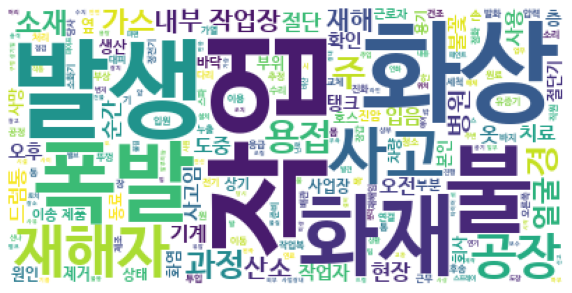

In [19]:
# wordcloud 패키지 다운로드
# !pip install wordcloud
# 가장 많이 나온 단어 상위 200개 WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
wc.generate_from_frequencies(top_nouns)
# World
# 많이 나타나는 단어일수록 크게 나타남

figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)
wc.to_file(filename="WC_ENTIRE.png") # to_file 함수

In [23]:
word_embeddings_transpose = word_embeddings.transpose()
word_embeddings_transpose # 전치 행렬
term_document_matrix = word_embeddings.dot(word_embeddings_transpose) # 행렬 * 전치행렬
term_document_matrix[:50] # 동시 단어 행렬


,작업,화상,발생,불,폭발,화재,사고,재해자,공장,용접,...,보일러실,용광로,영업,활용,과정중,처리장,메탄가스,게이지,화요일,유압오일
작업,2.321558,1.189936,1.493613,1.699100,1.657490,1.440046,1.475461,1.746914,2.045778,2.122780,...,1.563298,1.517388,1.312573,1.611813,1.470614,1.382174,1.618565,1.638021,1.347003,1.359985
화상,1.189936,3.612477,2.700598,3.203981,2.414011,2.582665,2.564461,1.739703,0.984292,1.677761,...,1.541517,1.552357,1.308545,1.568434,1.553679,1.394527,1.719541,1.623734,1.368471,1.450425
발생,1.493613,2.700598,2.616754,2.477157,2.108467,2.764311,2.184694,1.749709,1.366308,1.665143,...,1.534903,1.509974,1.288744,1.530530,1.502776,1.373994,1.644221,1.593965,1.339987,1.394395
불,1.699100,3.203981,2.477157,3.498648,2.387980,2.223541,2.421443,1.783910,1.256053,2.171766,...,1.570414,1.595384,1.340242,1.657834,1.580228,1.410620,1.771428,1.681456,1.389349,1.473010
폭발,1.657490,2.414011,2.108467,2.387980,2.171873,1.923086,2.047155,1.654803,1.363437,1.795213,...,1.495033,1.485447,1.263084,1.547850,1.458988,1.332690,1.624365,1.586533,1.301874,1.362087
화재,1.440046,2.582665,2.764311,2.223541,1.923086,3.248041,2.122921,1.825728,1.510739,1.532729,...,1.573591,1.520496,1.311609,1.512240,1.527211,1.410331,1.638394,1.599763,1.373721,1.406649
사고,1.475461,2.564461,2.184694,2.421443,2.047155,2.122921,2.069356,1.641171,1.280293,1.672615,...,1.465262,1.452168,1.237120,1.491885,1.437651,1.313895,1.586928,1.539685,1.283494,1.338803
재해자,1.746914,1.739703,1.749709,1.783910,1.654803,1.825728,1.641171,1.676953,1.684230,1.707671,...,1.487399,1.442466,1.246973,1.489408,1.419846,1.327103,1.543113,1.540490,1.295206,1.310184
공장,2.045778,0.984292,1.366308,1.256053,1.363437,1.510739,1.280293,1.684230,2.048152,1.785029,...,1.500399,1.432891,1.251783,1.497157,1.397393,1.332453,1.507662,1.542744,1.296483,1.284186
용접,2.122780,1.677761,1.665143,2.171766,1.795213,1.532729,1.672615,1.707671,1.785029,2.146378,...,1.520295,1.496374,1.282941,1.583266,1.458427,1.348665,1.616075,1.604960,1.319924,1.350910


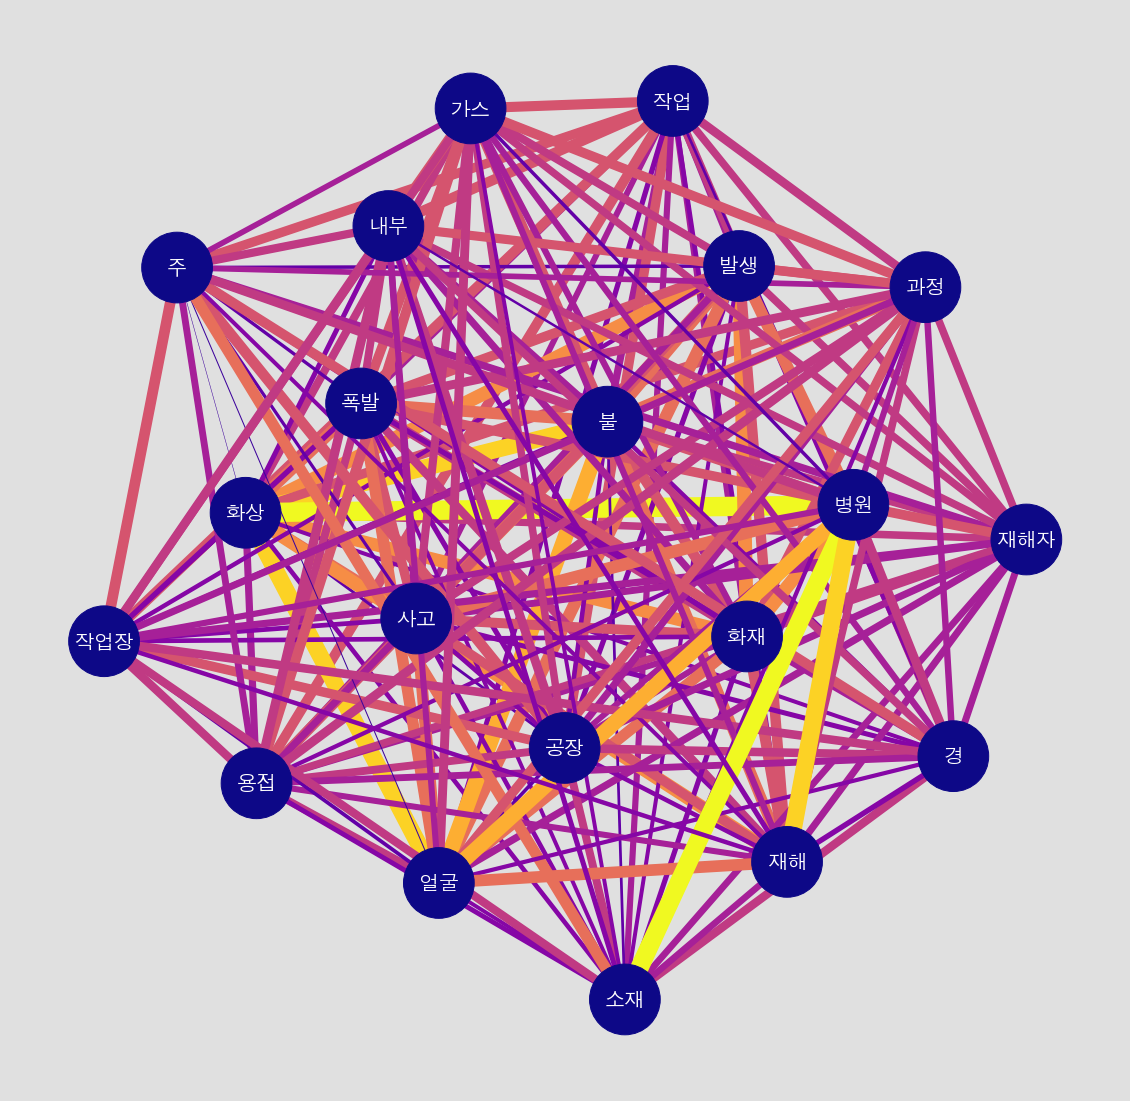

In [21]:
# 단어가 너무 많아서 index 상에서 상위 10개만 시각화
visualization_num = 20
from matplotlib import cm
network = nx.from_numpy_matrix(term_document_matrix.to_numpy())
G=nx.Graph(name='Law Interaction Graph')
for i in range(len(term_document_matrix[:visualization_num])):
    for j in range(i+1,len(term_document_matrix[:visualization_num])):
        a = term_document_matrix.index[i] # cos_sim a node
        b = term_document_matrix.index[j] # cos_sim b node
        w = float(term_document_matrix.iloc[i].iloc[j]) # score as weighted edge where high scores = low weight
        G.add_weighted_edges_from([(a,b,w)])

def rescale(l,newmin,newmax):
    arr = list(l)
    return [(x-min(arr))/((max(arr)-min(arr))+0.1)*(newmax-newmin)+newmin for x in arr]
# use the matplotlib plasma colormap
graph_colormap = cm.get_cmap('plasma', 12)
# node color varies with Degree
c = rescale([G.degree(v) for v in G],0.0,0.9) 
c = [graph_colormap(i) for i in c]
# node size varies with betweeness centrality - map to range [10,100] 
bc = nx.betweenness_centrality(G) # betweeness centrality
s =  rescale([v for v in bc.values()],5000,7000)
# edge width shows 1-weight to convert cost back to strength of interaction 
ew = rescale([float(G[u][v]['weight']) for u,v in G.edges],0.5,20)
# edge color also shows weight
ec = rescale([float(G[u][v]['weight']) for u,v in G.edges],0.1,1)
ec = [graph_colormap(i) for i in ec]
pos = nx.spring_layout(G)
plt.figure(figsize=(20,20),facecolor=[0.7,0.7,0.7,0.4])

nx.draw_networkx(G,
                 pos = pos,
                 with_labels = True,
                 node_color = c,
                 node_size = s,
                 edge_color = ec,
                 width = ew,
                 font_color ='white',
                 font_weight ='bold',
                 font_size ='20',
                 font_family = 'AppleGothic')
plt.axis('off')
# plt.show()
plt.savefig('network_image')

# 2. 재해개요에 대해 DTM만들고 DBSCAN 클러스터링 수행 (TF-IDF)

In [25]:
df
df_stopwords
posts = df.get("재해개요")
posts

0       주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우징...
1       [비보고 사유] 가스주입실에서 이송대기중 질소가스통 체결부위 불량으로 폭발되면서 파...
2       [비보고 사유] 재해 발생시 산업재해발생 보고를 해야 한다는 사실을 알지 못함 [조...
3       [비보고 사유] 재해자가 본인 실수로 다쳤으므로 본인이 알아서 한다고 하여 방치한 ...
4       [비보고 사유] 공상처리 [조사자 견해] 유성기업(주)에서 제출한 공상처리 내역 및...
                              ...                        
1814    상기일 상기인 호스를 연결하기 위해 녹이는 과정에서 사고가 발생.(신나에 불이 옮겨...
1815    12월 07일 오전07시경 제품(무거리) 보관용기로 사용하기 위해 폐드럼통 뚜껑 산...
1816    2017년 12월 12일 14시 48분경 회사 공장동에서 기계시운전을 하면서 온도상...
1817    2017년 12월 18일 13시경 부산시 강서구 송정동 소재 부광화학공업(주) 본공...
1818    2017년 12월 18일 13시경 부산시 강서구 송정동 소재 부광화학공업(주) 본공...
Name: 재해개요, Length: 1819, dtype: object

In [26]:
# vectorize = TfidfVectorizer(
#     tokenizer = tokenizer_2, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
#     min_df = 10,            # 단어가 출현하는 최소 문서의 개수
#     sublinear_tf = True,    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
#     stop_words = list(stop_words_df.get("불용어"))
# )
tfidf_vectorizer = TfidfVectorizer(min_df = 2,
                                  sublinear_tf = True,
                                  stop_words = list(df_stopwords.get("불용어")),
                                  max_features = 100)
tfidf_vectorizer.fit(posts) # 벡터라이저가 단어들을 학습합니다.
# tfidf_vectorizer.vocabulary_ # 벡터라이저가 학습한 단어사전을 출력합니다. 
# sorted(tfidf_vectorizer.vocabulary_.items()) # 단어사전을 정렬합니다.
# tfidf_vectorizer.vocabulary_.items()
X = tfidf_vectorizer.transform(posts)
pd.DataFrame(X.toarray())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '다시', '달려', '대로', '되는', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '못하다하기보다는', '미치다', '바꾸어서', '바꿔', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '틀림없다', '편이', '하고', '하기', '하기만', '하는', '하는것만', '하는것이', '하면', '하지', '한하다', '할수록', '함으로써', '해도', '해서는', '형식으로', '힘이'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.192963,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.180484,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.261997,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.447684,0.000000,0.0,0.0,0.000000,0.0
1815,0.0,0.0,0.0,0.0,0.0,0.0,0.419396,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.174500,0.0,0.0,0.000000,0.0
1816,0.0,0.0,0.0,0.0,0.0,0.0,0.701396,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
1817,0.0,0.0,0.0,0.0,0.0,0.0,0.374461,0.0,0.0,0.0,...,0.354399,0.0,0.0,0.0,0.000000,0.155804,0.0,0.0,0.241926,0.0


0.8008907219845698


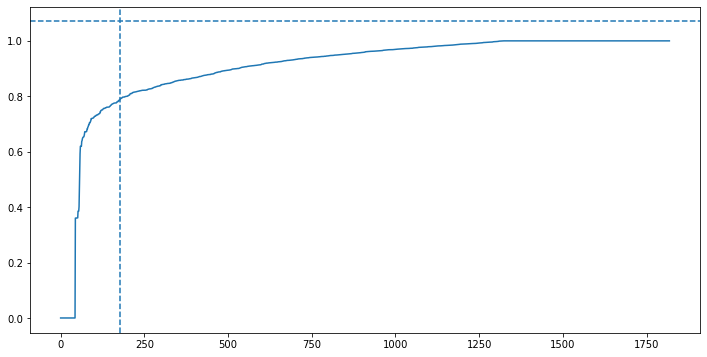

In [27]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(178, 0, 2, ls='--')
plt.axhline(1.07, 0, 200, ls='--')
print(np.sort(distances[:, 4])[200])

In [28]:
dbscan = DBSCAN(eps = 0.5, min_samples=5)
ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(pd.DataFrame(X.toarray())))
# dbscan = DBSCAN(eps = 0.5)
dbscan_cluster = dbscan.fit_predict(scaled_df)
dbscan_cluster

array([-1, -1, -1, ..., -1, -1, -1])

In [29]:
df["연번"]

0           43
1          120
2          197
3          394
4          478
         ...  
1814    495010
1815    495567
1816    495930
1817    496127
1818    496163
Name: 연번, Length: 1819, dtype: int64

In [30]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

dbscan_clustered_dic = {}
dbscan_clustered_list = []
# dbscan_cluster_num = len(set(dbscan_cluster))
dbscan_clustered_label = {}
for idx,i in enumerate(dbscan_cluster):
    if i not in dbscan_clustered_dic:
        dbscan_clustered_dic[i] = [df['재해개요'].iloc[idx]]
    else:
        dbscan_clustered_dic[i].append(df['재해개요'].iloc[idx])
    if i not in dbscan_clustered_label:
        dbscan_clustered_label[i] = [df["연번"].iloc[idx]]
    else:
        dbscan_clustered_label[i].append(df["연번"].iloc[idx])
dbscan_clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

dbscan_clustered_dic = sorted(dbscan_clustered_dic.items(), key=lambda x: x[0])
dbscan_clustered_dic
dbscan_clustered_label_list = []
for i in dbscan_clustered_label.items():
    dbscan_clustered_label_list.append(i[1])


In [31]:
df_dbscan_cluster = pd.DataFrame(dbscan_clustered_dic,columns=['num','clusters'])
dbscan_cluster_num = [len(i) for i in df_dbscan_cluster['clusters']]
df_dbscan_cluster['cluster_num'] = dbscan_cluster_num
df_dbscan_cluster['cluster_label'] = dbscan_clustered_label_list
df_dbscan_cluster

,num,clusters,cluster_num,cluster_label
0,-1,[주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우...,1775,"[43, 120, 197, 394, 478, 636, 672, 963, 1388, ..."
1,0,"[상기환자 반사로 앞에서 원료를 투입하던중 폭발과 함께 수상당하심, 압축기가 고압으...",15,"[5922, 34312, 66463, 102053, 149548, 154000, 1..."
2,1,[2012.04.06(금) 탄소섬유 공정 중 섬유를 전기히터를 통해 열풍으로 가열하...,5,"[29671, 29777, 29778, 29783, 29898]"
3,2,[2012년 7월13일 (금요일) 16시17분경 근무처인 신라에스지(주) 부산공장에...,5,"[53811, 53831, 53833, 53922, 53936]"
4,3,[2012년 8월 23일(목) 10시 10분경 OLED동 2층 합성실에서 Recei...,5,"[62867, 62912, 62990, 62991, 63007]"
5,4,[생산부 세척동 필터하우징 용기(카트리지) 세척공정에서 본인과 동료작업자 7명이 같...,8,"[248432, 248439, 248456, 248494, 248498, 24850..."
6,5,"[롯데케미칼 울산1공장 정기보수작업(10/12~10/29 : 18일) 기간 중에, ...",6,"[487970, 488033, 488081, 488123, 488160, 488202]"


# K-means clustering

In [32]:
tsne2 = TSNE(random_state=0,
             learning_rate = 50,
             n_components = 2)
tsne2_features = tsne2.fit_transform(pd.DataFrame(X.toarray()))

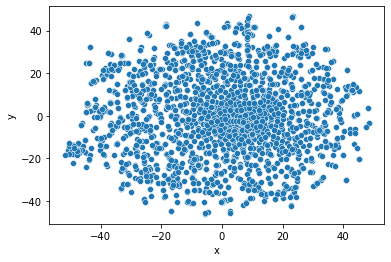

In [33]:
df_tsne = pd.DataFrame()
df_tsne['x'] = tsne2_features[:,0]
df_tsne['y'] = tsne2_features[:,1]
sns.scatterplot(x="x",y="y",data = df_tsne)
plt.show()

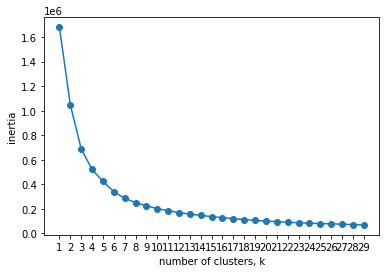

In [34]:
ks = range(1,30)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(tsne2_features)
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


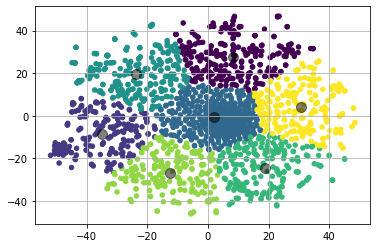

In [35]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters)
# kmeans = KMeans(n_clusters=4,verbose = 1)
kmeans

# 모델에 fitting 하기
kmeans.fit(tsne2_features)

y_kmeans = kmeans.predict(tsne2_features)
y_kmeans[0:10] # 군집화 된 결과

plt.scatter(np.array(tsne2_features)[:,0], np.array(tsne2_features)[:,1], c=y_kmeans, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5)
plt.grid()
plt.show()


In [36]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

clustered_dic = {}
clustered_list = []
cluster_num = len(set(y_kmeans))
k_means_cluster_label = {}
for idx,i in enumerate(y_kmeans):
    if i not in clustered_dic:
        clustered_dic[i] = [df['재해개요'].iloc[idx]]
    else:
        clustered_dic[i].append(df['재해개요'].iloc[idx])
    if i not in k_means_cluster_label:
        k_means_cluster_label[i] = [df["연번"].iloc[idx]]
    else:
        k_means_cluster_label[i].append(df["연번"].iloc[idx])
clustered_dic

k_means_cluster_label_list = []
for i in k_means_cluster_label.items():
    k_means_cluster_label_list.append(i[1])


# 클러스터링이 된 패키지들
# 20개의 군집으로 생성
clustered_dic = sorted(clustered_dic.items(), key=lambda x: x[0])
clustered_dic
df_cluster = pd.DataFrame(clustered_dic,columns=['num','clusters'])
cluster_num = [len(i) for i in df_cluster['clusters']]
df_cluster['cluster_num'] = cluster_num
df_cluster['cluster_label'] = k_means_cluster_label_list
df_cluster

,num,clusters,cluster_num,cluster_label
0,0,[[비보고 사유] 재해자가 본인 실수로 다쳤으므로 본인이 알아서 한다고 하여 방치한...,274,"[43, 120, 197, 1388, 1525, 4276, 5113, 8017, 8..."
1,1,"[숙소(컨테이너)에서 발생한 화재(경찰조사결과, 담뱃불에 의한 화재로 추정)로 인하...",218,"[394, 3112, 3420, 7407, 9595, 10655, 12237, 13..."
2,2,[[비보고 사유] 개인 휴가중에 발생한 개인적 업무를 보다 발생한 사고라서 생각하여...,377,"[478, 636, 7567, 7933, 8391, 10807, 11171, 116..."
3,3,[[비보고 사유] 공상처리 [조사자 견해] 유성기업(주)에서 제출한 공상처리 내역 ...,260,"[672, 3294, 4892, 5922, 5940, 6352, 7286, 7499..."
4,4,[[비보고 사유] 이천만원 이하 공사인 관계로 산재처리 되지 않는다고 하여서 [조사...,225,"[963, 3588, 5927, 7306, 7826, 8230, 8273, 1140..."
5,5,"[용접기 가스 교체 도중, 게이지 폭발하여 눈에 상처 입음, 12월 26일 저녁에 ...",232,"[1973, 6916, 10759, 14000, 14714, 16312, 16705..."
6,6,[주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우...,233,"[2545, 8527, 9084, 10323, 15013, 20025, 22086,..."


In [37]:
tsne2_df = pd.DataFrame(tsne2_features, index=df["연번"], columns=['x_coord', 'y_coord'])
tsne2_df['word'] = tsne2_df.index
tsne2_df

,x_coord,y_coord,word
연번,,,
43,40.645817,13.479643,43
120,27.575211,-10.950244,120
197,34.168526,-6.984909,197
394,2.790316,30.594320,394
478,-27.316324,25.971407,478
...,...,...,...
495010,15.817883,17.389933,495010
495567,-15.496833,21.428650,495567
495930,-13.333824,-1.977375,495930


In [38]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()
# prepare the data in a form suitable for bokeh.
plot_data = ColumnDataSource(tsne2_df)

# create the plot and configure it
tsne_plot = figure(title='t-SNE Sentence Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   active_scroll='wheel_zoom'
                  )

# add a hover tool to display words on roll-over
tsne_plot.add_tools(HoverTool(tooltips = '@word') )

tsne_plot.circle('x_coord', 'y_coord', source=plot_data,
                 color='red', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color='orange')

# adjust visual elements of the plot
tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# show time!
show(tsne_plot);

Loading BokehJS ...

{'작업': 159, '화상': 102, '발생': 87, '화재': 60, '폭발': 58, '불': 57, '사고': 32, '얼굴': 30, '재해': 29, '절단': 29, '공장': 29, '주': 28, '산소': 28, '작업장': 26, '재해자': 25, '내부': 25, '불꽃': 24, '소재': 24, '과정': 24, '가스': 22, '순간': 22, '경': 21, '작업자': 19, '입음': 19, '확인': 19, '층': 18, '현장': 17, '사고임': 16, '원인': 16, '용접': 15, '제품': 15, '기계': 14, '이용': 14, '화염': 14, '치료': 14, '사용': 14, '옷': 14, '본인': 14, '세척': 14, '차량': 14, '통': 14, '제거': 13, '병원': 13, '가열': 13, '생산': 13, '부위': 12, '사업장': 12, '절단기': 12, '도중': 12, '당사': 12, '오후': 12, '압력': 12, '사유': 11, '이송': 11, '회사': 11, '옆': 11, '바지': 11, '파편': 10, '내용': 10, '입원': 10, '호스': 10, '전기': 10, '연결': 10, '사망': 10, '상태': 10, '오전': 10, '부분': 10, '소': 9, '안': 9, '점화': 9, '근무': 9, '공정': 9, '에어': 9, '몸': 9, '작업복': 8, '근로자': 8, '스프레이': 8, '번지': 8, '페인트': 8, '드럼통': 8, '시설': 8, '용기': 8, '직원': 8, '팀': 8, '공기': 8, '장': 7, '토치': 7, '비산': 7, '준비': 7, '배터리': 7, '공장내': 7, '기름': 7, '발화': 7, '장갑': 7, '진압': 7, '다리': 7, '배관': 7, '반응': 7, '청소': 7, '자켓': 7, '연기': 7, '스파': 7, '일부': 7, '

{'작업': 124, '화상': 91, '발생': 86, '폭발': 76, '화재': 63, '불': 59, '사고': 38, '재해자': 34, '소재': 34, '내부': 33, '공장': 30, '경': 29, '과정': 25, '용접': 25, '얼굴': 24, '가스': 24, '드럼통': 23, '순간': 22, '사망': 21, '주': 21, '재해': 20, '현장': 16, '사용': 16, '산소': 16, '병원': 16, '층': 15, '옆': 15, '부위': 15, '기계': 15, '오후': 14, '원인': 14, '절단': 14, '치료': 14, '불꽃': 14, '작업장': 14, '확인': 13, '오전': 13, '입음': 13, '배관': 13, '작업자': 13, '용기': 12, '해체': 12, '진행': 12, '충격': 12, '바닥': 12, '제거': 11, '동료': 11, '옷': 11, '점검': 11, '회사': 11, '전기': 11, '용탕': 11, '도중': 10, '사업장': 10, '사고임': 10, '압력': 10, '입원': 10, '번지': 10, '원': 10, '절단기': 10, '통': 10, '상태': 10, '세척': 9, '사원': 9, '몸': 9, '펌프': 9, '직원': 9, '탱크': 9, '이송': 9, '주변': 8, '동': 8, '공정': 8, '근로자': 8, '가열': 8, '투입': 8, '부분': 8, '상기': 8, '응급': 8, '시': 8, '호스': 8, '본인': 8, '수리': 8, '일부': 8, '대피': 8, '주입': 8, '업무': 7, '뚜껑': 7, '스파': 7, '재해임': 7, '시설': 7, '누출': 7, '연결': 7, '시험': 7, '화염': 7, '집진기': 7, '목': 7, '후송': 7, '진압': 7, '반응': 7, '파편': 7, '밸브': 7, '작업복': 7, '작동': 7, '안': 6, '기

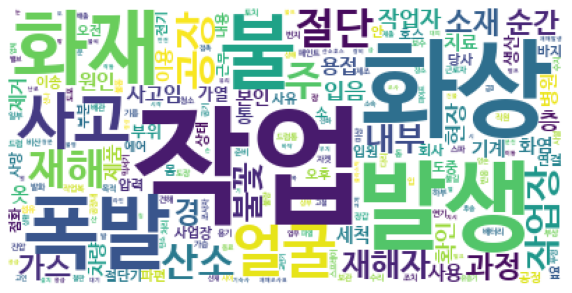

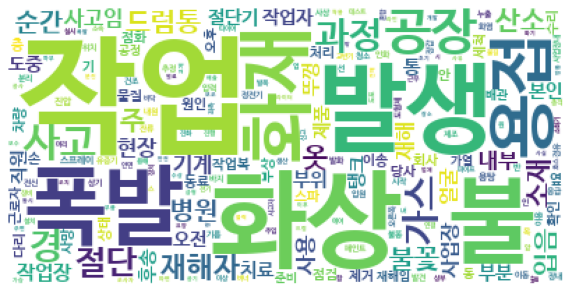

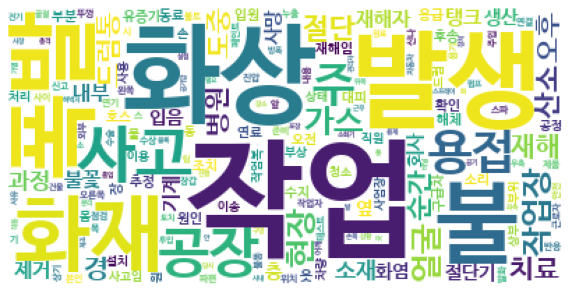

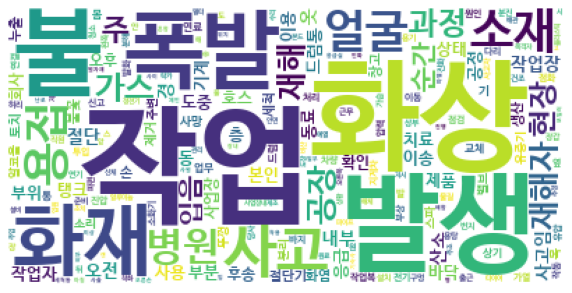

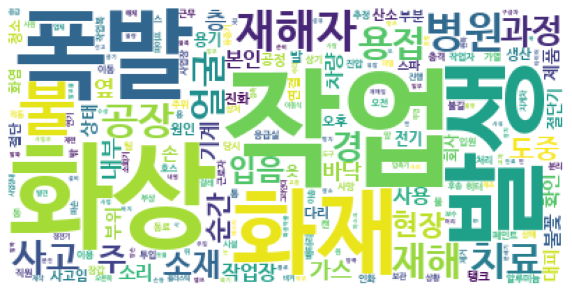

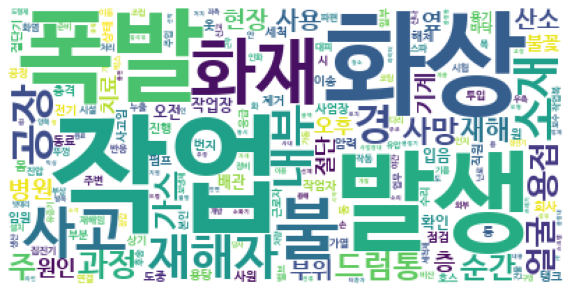

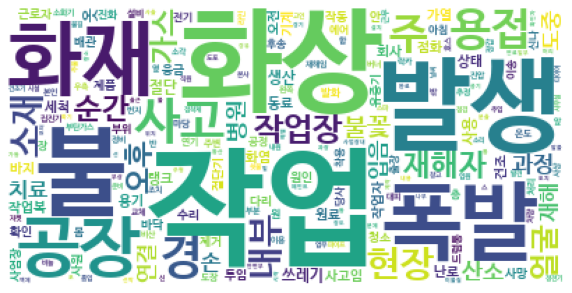

In [83]:
# for idx,sentence in enumerate(sentence_nouns_list):
#     print(sentence)
num_top_nouns = 200
for index,clus in enumerate(df_cluster["cluster_label"]):
    temp_morphs_list = []
    for c in clus:
        s_index = df[df["연번"]==c].index[0]
        for i in sentence_nouns_list[s_index]:
            temp_morphs_list.append(i)
    nouns_counter = Counter(temp_morphs_list)
    top_nouns = dict(nouns_counter.most_common(num_top_nouns)[:200])
    wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
    wc.generate_from_frequencies(top_nouns)
    print(top_nouns)
    # World
    # 많이 나타나는 단어일수록 크게 나타남

    figure = plt.figure()
    figure.set_size_inches(10, 10)
    ax = figure.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(wc)
    wc.to_file(filename="WC_K-Means{}.png".format(index)) # to_file 함수